<>:379: SyntaxWarning: invalid escape sequence '\m'
<>:379: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-2053145615.py:379: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Decoder image of φ-grid in $\mathbb{R}^2$")



=== Phase 1 | epochs=500 | W_REC=15.0 W_CONJ=0.0 W_LAT1=0.0 | lr=0.002 ===
  ep    1 | rec 5.553e-01 | conj 0.000e+00 | lat1 0.000e+00 | total 8.330e+00
  ep  100 | rec 1.472e-02 | conj 0.000e+00 | lat1 0.000e+00 | total 2.208e-01
  ep  200 | rec 7.200e-03 | conj 0.000e+00 | lat1 0.000e+00 | total 1.080e-01
  ep  300 | rec 4.256e-03 | conj 0.000e+00 | lat1 0.000e+00 | total 6.384e-02
  ep  400 | rec 2.101e-03 | conj 0.000e+00 | lat1 0.000e+00 | total 3.152e-02
  ep  500 | rec 1.920e-03 | conj 0.000e+00 | lat1 0.000e+00 | total 2.879e-02

=== Phase 2 | epochs=250 | W_REC=10.0 W_CONJ=0.5 W_LAT1=0.2 | lr=0.0015 ===
  ep    1 | rec 3.373e-03 | conj 6.866e-02 | lat1 1.083e-03 | total 6.827e-02
  ep  100 | rec 1.750e-03 | conj 2.573e-02 | lat1 5.527e-04 | total 3.047e-02
  ep  200 | rec 1.525e-03 | conj 2.327e-03 | lat1 7.428e-04 | total 1.656e-02

=== Phase 3 | epochs=250 | W_REC=7.0 W_CONJ=1.0 W_LAT1=0.5 | lr=0.001 ===
  ep    1 | rec 1.896e-03 | conj 2.484e-03 | lat1 6.011e-04 | total 1.

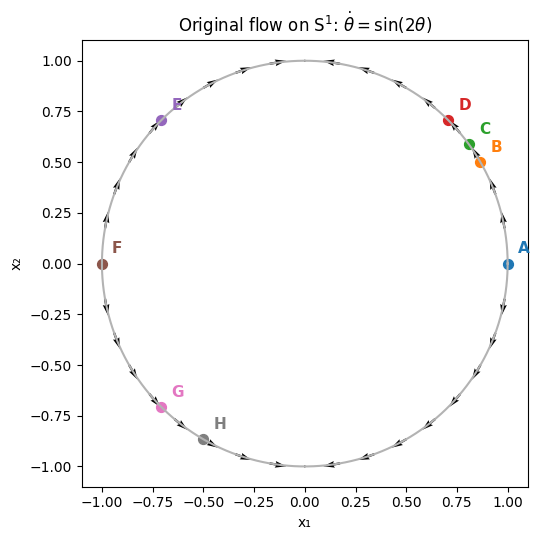

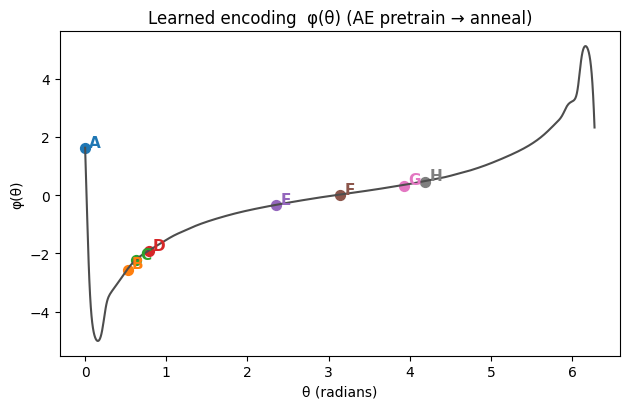

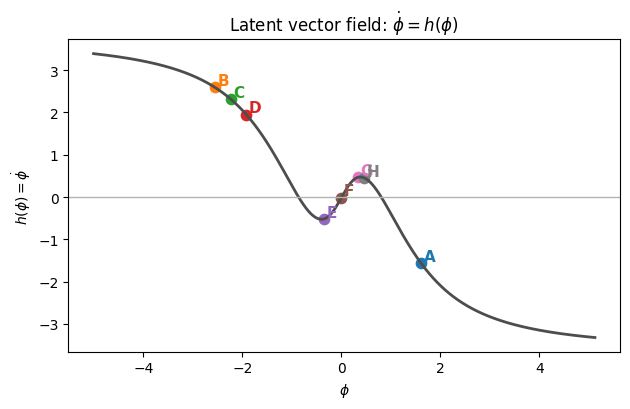

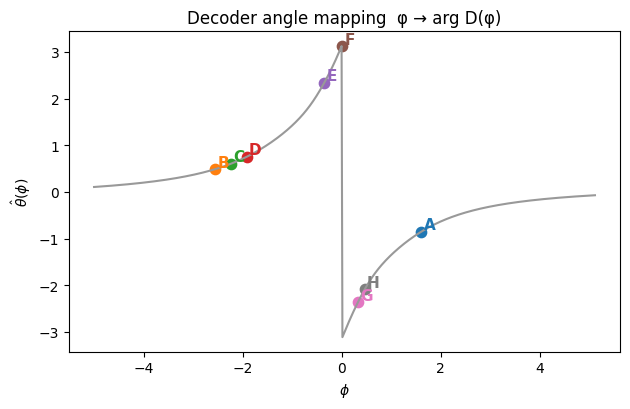

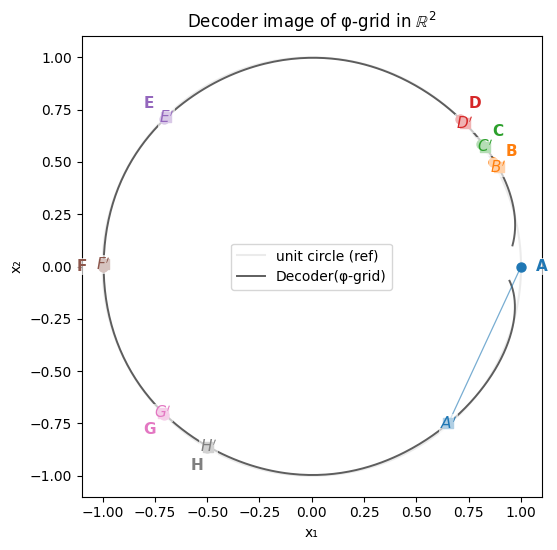


Decoded point radii (A'..H'):
  A': radius = 0.993745
  B': radius = 1.010407
  C': radius = 1.007190
  D': radius = 1.002262
  E': radius = 0.995478
  F': radius = 0.994763
  G': radius = 0.996367
  H': radius = 0.992740


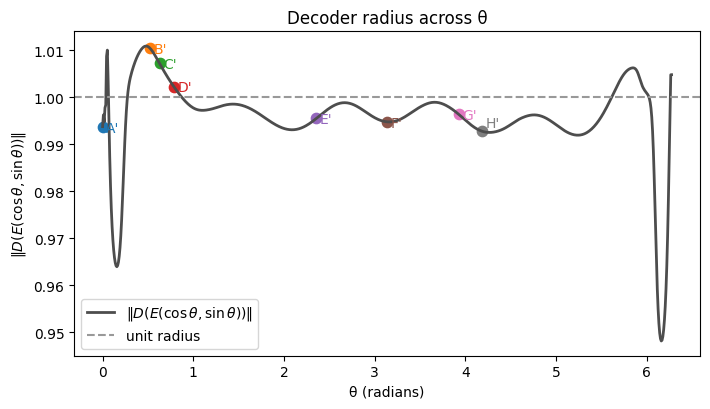

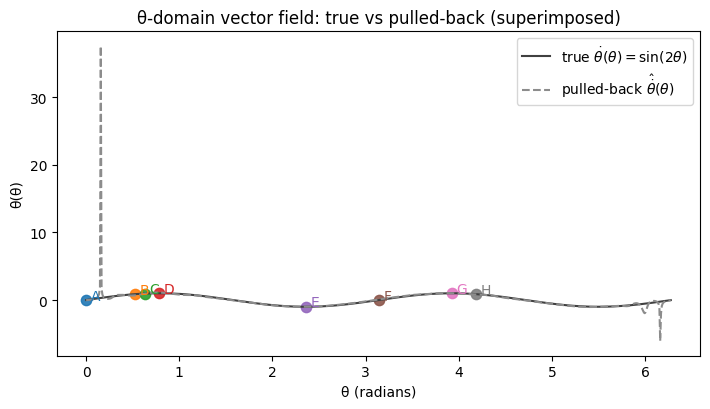

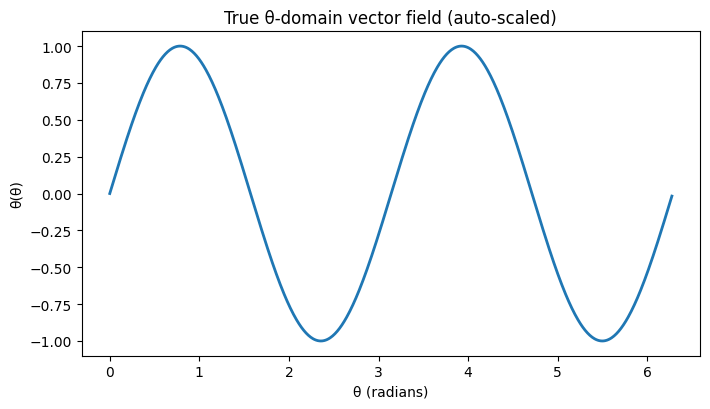

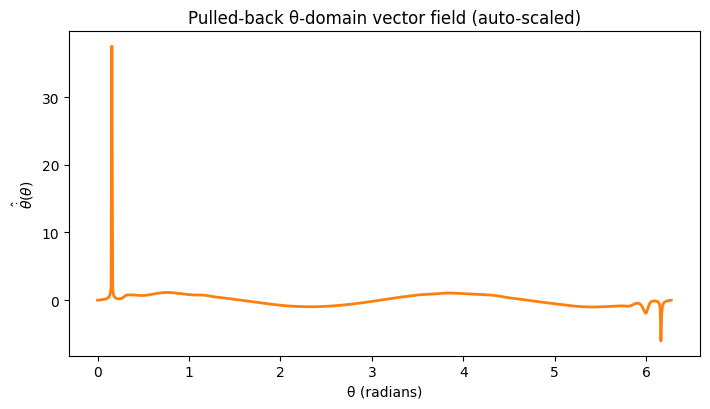

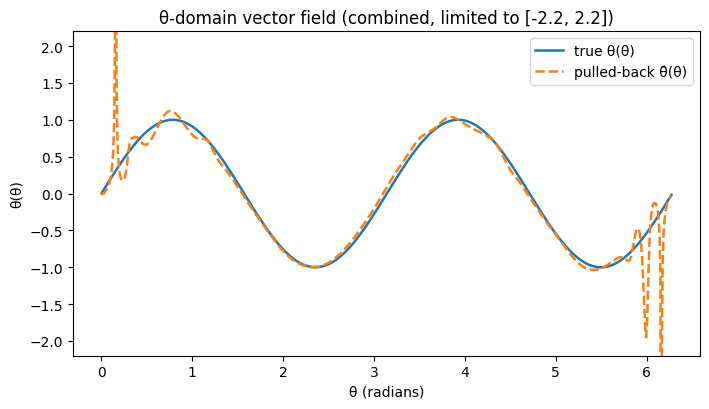

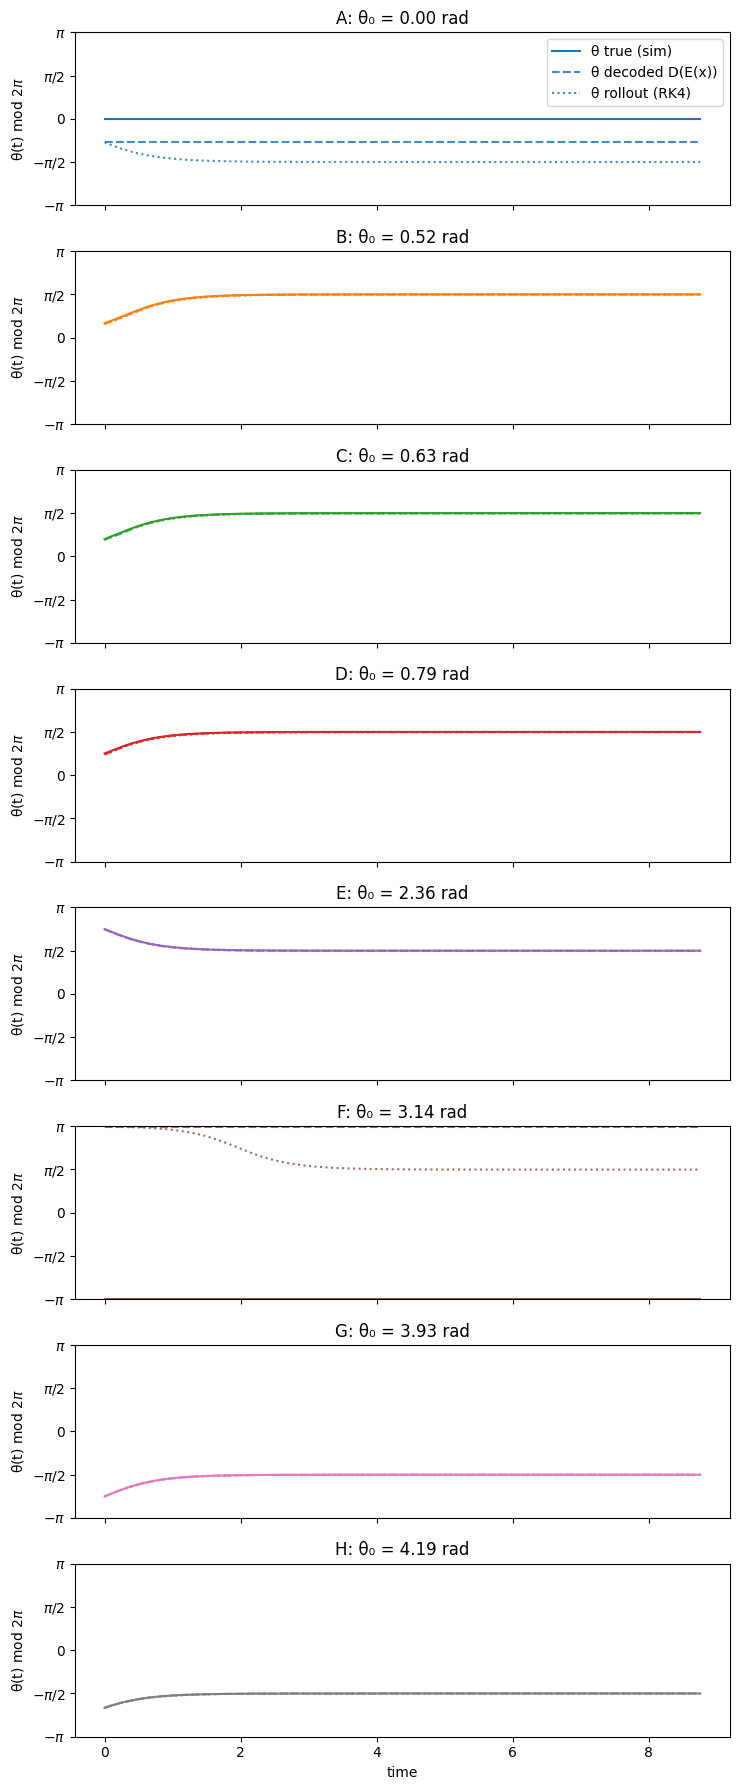

In [1]:
# ae_latentODE_twoPhase_pretrain_then_anneal_savefigs_combinedZoom_withRadius_FIXED.py
# - Phase 1: AE pretrain on ||D(E(x)) - x||^2
# - Phase 2..4: introduce conjugacy + latent RK4 losses (annealed)
# - Encoder: deep MLP R^2->R (no atan2 prior)
# - Decoder: unconstrained MLP R->R^2 (no projection)
# - Latent ODE: 1D MLP, RK4 stepping
# - Figures saved to ./results_latentODE/ with names matching LaTeX
# - "Zoom" figure is the combined true + pulled-back with y-lims [-2.2, 2.2]
# - Radius plot included; A'..H' radii printed to console
# - FIX: no usage of numpy .astype on torch tensors

import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ----------------------------
# Central output directory
# ----------------------------
SAVE_DIR = "./results_latentODE"
os.makedirs(SAVE_DIR, exist_ok=True)

def savefig(name):
    plt.savefig(os.path.join(SAVE_DIR, name), dpi=200, bbox_inches='tight')

# ----------------------------
# Repro / device
# ----------------------------
DEVICE = torch.device("cpu")
torch.set_default_dtype(torch.float32)
torch.manual_seed(0)
np.random.seed(0)

# ----------------------------
# Data & dynamics
# ----------------------------
DT       = 0.04
N_TRAJ   = 512
STEPS    = 96

def theta_dot(theta):
    return np.sin(2.0*theta)

def theta_to_xy(theta):
    return np.stack([np.cos(theta), np.sin(theta)], axis=-1).astype(np.float32)

def simulate_thetas(n_traj=N_TRAJ, steps=STEPS, dt=DT, seed=0):
    rng = np.random.default_rng(seed)
    theta0 = rng.uniform(0, 2*np.pi, size=n_traj)
    thetas = np.zeros((n_traj, steps), dtype=np.float32)
    thetas[:, 0] = theta0.astype(np.float32)
    for t in range(1, steps):
        th = thetas[:, t-1]
        thetas[:, t] = (th + dt * theta_dot(th)).astype(np.float32)
    return thetas

thetas = simulate_thetas(seed=42)
X = theta_to_xy(thetas)              # (N,T,2)
X_flat = X.reshape(-1, 2)
X_t   = X[:, :-1, :].reshape(-1, 2)
X_tp1 = X[:,  1:, :].reshape(-1, 2)
X_tensor = torch.from_numpy(X_flat).to(DEVICE)
X_t      = torch.from_numpy(X_t).to(DEVICE)
X_tp1    = torch.from_numpy(X_tp1).to(DEVICE)

# ----------------------------
# Labeled initial conditions (A..H)
# ----------------------------
ICS = {
    "A": 0.0,
    "B": np.pi/6,
    "C": np.pi/5,
    "D": np.pi/4,
    "E": 3*np.pi/4,
    "F": np.pi,
    "G": 5*np.pi/4,
    "H": 4*np.pi/3,
}
TAG_LIST = list(ICS.keys())
COLOR_LIST = plt.rcParams['axes.prop_cycle'].by_key().get('color', None)
if COLOR_LIST is None or len(COLOR_LIST) < len(TAG_LIST):
    COLOR_LIST = ['C0','C1','C2','C3','C4','C5','C6','C7']
TAG_TO_COLOR = {tag: COLOR_LIST[i % len(COLOR_LIST)] for i, tag in enumerate(TAG_LIST)}

# ----------------------------
# Models
# ----------------------------
class EncoderDeep(nn.Module):
    def __init__(self, in_dim=2, hidden=128, depth=3, out_dim=1, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden), act()]
        for _ in range(depth-1):
            layers += [nn.Linear(hidden, hidden), act()]
        layers += [nn.Linear(hidden, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, in_dim=1, hidden=128, out_dim=2, act=nn.Tanh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), act(),
            nn.Linear(hidden, hidden), act(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, phi): return self.net(phi)  # no projection

class LatentODE(nn.Module):
    def __init__(self, in_dim=1, hidden=64, out_dim=1, act=nn.Tanh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), act(),
            nn.Linear(hidden, hidden), act(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, phi): return self.net(phi)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = EncoderDeep()
        self.dec = Decoder()
        self.h   = LatentODE()
    def forward(self, x):
        phi = self.enc(x)
        xhat = self.dec(phi)
        return xhat, phi

model = Model().to(DEVICE)

# ----------------------------
# Loss utilities
# ----------------------------
mse = nn.MSELoss()

def rk4_step(z, h, dt):
    k1 = h(z)
    k2 = h(z + 0.5*dt*k1)
    k3 = h(z + 0.5*dt*k2)
    k4 = h(z + dt*k3)
    return z + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def true_field_xy_from_any_x(x: torch.Tensor) -> torch.Tensor:
    """
    Exact vector field in R^2 (no unit-circle assumption):
        f(x) = (-2 x1 x2^2,  2 x1^2 x2)^T
    x: (B,2) tensor
    returns: (B,2) tensor
    """
    x1 = x[:, 0]
    x2 = x[:, 1]
    fx1 = -2.0 * x1 * (x2 ** 2)
    fx2 =  2.0 * (x1 ** 2) * x2
    return torch.stack([fx1, fx2], dim=1)

def conjugacy_loss(model, x_batch):
    x_batch = x_batch.requires_grad_(True)
    phi = model.enc(x_batch)
    phi.requires_grad_(True)
    x_dec = model.dec(phi)
    h_phi = model.h(phi)
    grads = []
    for i in range(2):
        g = torch.autograd.grad(x_dec[:, i].sum(), phi,
                                retain_graph=True, create_graph=True)[0]
        grads.append(g)
    J = torch.cat(grads, dim=1)   # (B,2)
    v_push = J * h_phi
    f_true = true_field_xy_from_any_x(x_dec)
    return ((v_push - f_true)**2).mean()

# ----------------------------
# Training schedules (two-phase / annealed)
# ----------------------------
SCHEDULE = [
    (500, 15.0, 0.0, 0.0, 2e-3),   # AE pretrain
    (250, 10.0, 0.5, 0.2, 1.5e-3),
    (250,  7.0, 1.0, 0.5, 1.0e-3),
    (250,  5.0, 2.0, 0.8, 1.0e-3),
]
BATCH = 4096
WEIGHT_DECAY = 1e-5

def train_with_schedule(model, schedule=SCHEDULE):
    N_all  = X_tensor.shape[0]
    N_pairs= X_t.shape[0]

    for phase, (EPOCHS, W_REC, W_CONJ, W_LAT1, LR) in enumerate(schedule, 1):
        opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        print(f"\n=== Phase {phase} | epochs={EPOCHS} | W_REC={W_REC} "
              f"W_CONJ={W_CONJ} W_LAT1={W_LAT1} | lr={LR} ===")
        for ep in range(EPOCHS):
            # Reconstruction batch
            idx = torch.randint(0, N_all, (BATCH,))
            xb  = X_tensor[idx]
            xhat, phi = model(xb)
            L_rec = mse(xhat, xb)

            # Conjugacy
            L_conj = torch.tensor(0.0, device=DEVICE)
            if W_CONJ > 0.0:
                idxc = torch.randint(0, N_all, (BATCH,))
                xc   = X_tensor[idxc]
                L_conj = conjugacy_loss(model, xc)

            # Latent one-step
            L_lat1 = torch.tensor(0.0, device=DEVICE)
            if W_LAT1 > 0.0:
                idxp = torch.randint(0, N_pairs, (BATCH,))
                xt, xtp1 = X_t[idxp], X_tp1[idxp]
                phi_t = model.enc(xt)
                phi_tp1_enc = model.enc(xtp1).detach()
                phi_tp1_pred = rk4_step(phi_t, model.h, DT)
                L_lat1 = mse(phi_tp1_pred, phi_tp1_enc)

            loss = W_REC*L_rec + W_CONJ*L_conj + W_LAT1*L_lat1

            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            if (ep+1) % 100 == 0 or ep == 0:
                print(f"  ep {ep+1:4d} | rec {L_rec.item():.3e} "
                      f"| conj {L_conj.item():.3e} | lat1 {L_lat1.item():.3e} "
                      f"| total {loss.item():.3e}")

train_with_schedule(model, SCHEDULE)

# ----------------------------
# Plot helpers
# ----------------------------
def wrap_angle_numpy(a):
    return ((a + np.pi) % (2*np.pi)) - np.pi

def annotate_points_on_circle(ax, labels_to_theta):
    for tag, th in labels_to_theta.items():
        x, y = np.cos(th), np.sin(th)
        ax.scatter([x], [y], s=50, color=TAG_TO_COLOR[tag])
        ax.text(x+0.05, y+0.05, tag, fontsize=11, weight='bold',
                color=TAG_TO_COLOR[tag])

def quiver_circle_with_labels():
    def f_on_circle_xy(theta):
        thdot = np.sin(2.0*theta)
        tx, ty = -np.sin(theta), np.cos(theta)
        return np.stack([thdot*tx, thdot*ty], axis=-1)
    theta_q = np.linspace(0, 2*np.pi, 36, endpoint=False)
    circle = np.stack([np.cos(theta_q), np.sin(theta_q)], axis=-1)
    vecs = f_on_circle_xy(theta_q)
    vecs = vecs / np.maximum(1e-8, np.linalg.norm(vecs, axis=-1, keepdims=True))
    plt.figure(figsize=(5.5,5.5))
    td = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(td), np.sin(td), color='0.7')
    plt.quiver(circle[:,0], circle[:,1], vecs[:,0], vecs[:,1],
               angles='xy', scale_units='xy', scale=12, width=0.005)
    annotate_points_on_circle(plt.gca(), ICS)
    plt.gca().set_aspect('equal', 'box')
    plt.title(r"Original flow on S$^1$: $\dot{\theta} = \sin(2\theta)$")
    plt.xlabel("x₁"); plt.ylabel("x₂")
    plt.tight_layout()
    savefig("fig_flow_S1.png")
    plt.show()

def phi_of_theta_with_labels():
    theta_line = np.linspace(0, 2*np.pi, 720, endpoint=False)
    xy_line = np.stack([np.cos(theta_line), np.sin(theta_line)], axis=-1).astype(np.float32)
    with torch.no_grad():
        phi_line = model.enc(torch.from_numpy(xy_line).to(DEVICE)).cpu().numpy().reshape(-1)
    phi_line -= np.mean(phi_line)
    plt.figure(figsize=(6.4,4.2))
    plt.plot(theta_line, phi_line, color='0.3')
    for tag, th in ICS.items():
        with torch.no_grad():
            phi_tag = model.enc(torch.from_numpy(np.array([[np.cos(th), np.sin(th)]], np.float32)).to(DEVICE)).cpu().numpy().squeeze()
        phi_tag -= np.mean(phi_line)
        plt.scatter([th],[phi_tag], s=50, color=TAG_TO_COLOR[tag])
        plt.text(th+0.05, phi_tag+0.05, tag, fontsize=11, weight='bold', color=TAG_TO_COLOR[tag])
    plt.xlabel("θ (radians)"); plt.ylabel("φ(θ)")
    plt.title("Learned encoding  φ(θ) (AE pretrain → anneal)")
    plt.tight_layout()
    savefig("fig_phi_of_theta.png")
    plt.show()

def plot_latent_vector_field_with_labels():
    theta_line = np.linspace(0, 2*np.pi, 720, endpoint=False)
    xy_line = np.stack([np.cos(theta_line), np.sin(theta_line)], axis=-1).astype(np.float32)
    with torch.no_grad():
        phi_line = model.enc(torch.from_numpy(xy_line).to(DEVICE)).cpu().numpy().reshape(-1)
    phi_line = phi_line - np.mean(phi_line)
    phi_grid = np.linspace(phi_line.min(), phi_line.max(), 500, dtype=np.float32)
    with torch.no_grad():
        h_vals = model.h(torch.from_numpy(phi_grid).float().unsqueeze(1).to(DEVICE)).cpu().numpy().reshape(-1)
    plt.figure(figsize=(6.4,4.2))
    plt.plot(phi_grid, h_vals, linewidth=2, color='0.3')
    for tag, th in ICS.items():
        with torch.no_grad():
            phi_tag = model.enc(torch.from_numpy(np.array([[np.cos(th), np.sin(th)]], np.float32)).to(DEVICE)).cpu().numpy().squeeze()
            h_tag   = model.h(torch.from_numpy(np.array([[phi_tag]], np.float32)).to(DEVICE)).cpu().numpy().squeeze()
        phi_tag -= np.mean(phi_line)
        plt.scatter([phi_tag],[h_tag], s=55, color=TAG_TO_COLOR[tag])
        plt.text(phi_tag+0.05, h_tag+0.05, tag, fontsize=11, weight='bold', color=TAG_TO_COLOR[tag])
    plt.axhline(0, linewidth=1, color='0.7')
    plt.xlabel(r"$\phi$"); plt.ylabel(r"$h(\phi)=\dot{\phi}$")
    plt.title(r"Latent vector field: $\dot{\phi} = h(\phi)$")
    plt.tight_layout()
    savefig("fig_latent_vf.png")
    plt.show()

def plot_decoder_mapping_views():
    theta_line = np.linspace(0, 2*np.pi, 720, endpoint=False)
    xy_line = np.stack([np.cos(theta_line), np.sin(theta_line)], axis=-1).astype(np.float32)
    with torch.no_grad():
        phi_obs = model.enc(torch.from_numpy(xy_line).to(DEVICE)).cpu().numpy().reshape(-1)
    phi_obs = phi_obs - np.mean(phi_obs)
    phi_grid = np.linspace(phi_obs.min(), phi_obs.max(), 600, dtype=np.float32)

    with torch.no_grad():
        x_dec = model.dec(torch.from_numpy(phi_grid).float().reshape(-1,1).to(DEVICE)).cpu().numpy()
    theta_hat = np.arctan2(x_dec[:,1], x_dec[:,0])

    # (1) φ vs θ̂(φ)
    plt.figure(figsize=(6.4,4.2))
    plt.plot(phi_grid, theta_hat, color='0.6')
    for tag, th in ICS.items():
        with torch.no_grad():
            phi_tag = model.enc(torch.from_numpy(np.array([[np.cos(th), np.sin(th)]], np.float32)).to(DEVICE)).cpu().numpy().squeeze()
            x_tag  = model.dec(torch.from_numpy(np.array([[phi_tag]], np.float32)).to(DEVICE)).cpu().numpy().squeeze()
        phi_tag_c = phi_tag - np.mean(phi_obs)
        th_tag = np.arctan2(x_tag[1], x_tag[0])
        c = TAG_TO_COLOR[tag]
        plt.scatter([phi_tag_c],[th_tag], s=55, color=c)
        plt.text(phi_tag_c+0.05, th_tag+0.05, tag, fontsize=11, weight='bold', color=c)
    plt.xlabel(r"$\phi$"); plt.ylabel(r"$\hat{\theta}(\phi)$")
    plt.title("Decoder angle mapping  φ → arg D(φ)")
    plt.tight_layout()
    savefig("fig_decoder_angle.png")
    plt.show()

    # (2) Decoded curve in R^2
    plt.figure(figsize=(6.0,5.6))
    td = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(td), np.sin(td), alpha=0.25, color='0.7', label="unit circle (ref)")
    plt.plot(x_dec[:,0], x_dec[:,1], linewidth=1.4, alpha=0.9, color='0.3', label="Decoder(φ-grid)")

    outward = 0.10
    line_kw = dict(alpha=0.6, linewidth=0.9)
    orig_kw = dict(s=42, zorder=3)
    dec_kw  = dict(s=42, zorder=3)

    for tag in TAG_LIST:
        th = ICS[tag]
        x_orig = np.array([np.cos(th), np.sin(th)])
        with torch.no_grad():
            phi_tag = model.enc(torch.from_numpy(np.array([[x_orig[0], x_orig[1]]], np.float32)).to(DEVICE)).cpu().numpy().squeeze()
            x_decoded = model.dec(torch.from_numpy(np.array([[phi_tag]], np.float32)).to(DEVICE)).cpu().numpy().squeeze()

        c = TAG_TO_COLOR[tag]
        plt.plot([x_orig[0], x_decoded[0]],
                 [x_orig[1], x_decoded[1]],
                 color=c, **line_kw)
        plt.scatter([x_orig[0]],[x_orig[1]], marker='o', color=c, **orig_kw)
        plt.scatter([x_decoded[0]],[x_decoded[1]], marker='s', color=c, **dec_kw)

        L_out = (1.0 + outward) * x_orig
        plt.text(L_out[0], L_out[1], f"{tag}",
                 fontsize=11, weight='bold', color=c,
                 ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.65, pad=0.8))
        plt.text(x_decoded[0], x_decoded[1], r"$%s'$" % tag,
                 fontsize=11, weight='bold', color=c,
                 ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.65, pad=0.8))

    plt.gca().set_aspect('equal', 'box')
    plt.title("Decoder image of φ-grid in $\mathbb{R}^2$")
    plt.xlabel("x₁"); plt.ylabel("x₂")
    plt.legend(loc='best')
    plt.tight_layout()
    savefig("fig_decoder_R2.png")
    plt.show()

# ---------- Radius visualization + printout (FIXED) ----------
def plot_decoder_radius_and_print_radii():
    """
    Plot radius ||D(E(x))|| vs θ, overlay A..H, and print
    the numeric radii of A'..H' to the console.
    Now includes safe label placement.
    """
    theta_line = np.linspace(0, 2*np.pi, 720, endpoint=False)
    xy_line = np.stack([np.cos(theta_line), np.sin(theta_line)], axis=-1).astype(np.float32)

    with torch.no_grad():
        phi_line = model.enc(torch.from_numpy(xy_line).to(DEVICE)).cpu().numpy().reshape(-1)

    phi_tensor = torch.from_numpy(phi_line).float().reshape(-1,1).to(DEVICE)
    with torch.no_grad():
        x_dec = model.dec(phi_tensor).cpu().numpy()

    radii = np.linalg.norm(x_dec, axis=1)

    # --- Compute safe y-limits before plotting ---
    rmin, rmax = radii.min(), radii.max()
    pad = 0.05 * (rmax - rmin + 1e-5)
    y_lo = rmin - pad
    y_hi = rmax + pad

    plt.figure(figsize=(7.2,4.2))
    plt.plot(theta_line, radii, linewidth=2, color='0.3',
             label=r"$\|D(E(\cos\theta,\sin\theta))\|$")
    plt.axhline(1.0, color='0.6', linestyle='--', label="unit radius")

    print("\nDecoded point radii (A'..H'):")

    for tag, th in ICS.items():
        x_orig = np.array([np.cos(th), np.sin(th)], dtype=np.float32)
        with torch.no_grad():
            phi_tag = model.enc(torch.from_numpy(x_orig).unsqueeze(0).to(DEVICE)).cpu().numpy().squeeze()
            x_decoded = model.dec(
                torch.from_numpy(np.array([[phi_tag]], np.float32)).to(DEVICE)
            ).cpu().numpy().squeeze()

        r = float(np.linalg.norm(x_decoded))
        c = TAG_TO_COLOR[tag]
        plt.scatter([th], [r], color=c, s=55)

        # Safe label placement *inside* the axes
        # Shift upward or downward depending on where the radius sits.
        text_offset = 0.015
        r_text = r + text_offset*(y_hi - y_lo)
        if r_text > y_hi - 0.02:       # If too high, shift downward
            r_text = r - text_offset*(y_hi - y_lo)

        plt.text(th+0.04, r_text, rf"{tag}'", fontsize=10, color=c)

        print(f"  {tag}': radius = {r:.6f}")

    plt.ylim([y_lo, y_hi])
    plt.xlabel("θ (radians)")
    plt.ylabel(r"$\|D(E(\cos\theta,\sin\theta))\|$")
    plt.title("Decoder radius across θ")
    plt.legend(loc="best")
    plt.tight_layout()
    savefig("fig_decoder_radius.png")
    plt.show()

def simulate_theta(theta0, steps=220, dt=DT):
    th = float(theta0); out = []
    for _ in range(steps):
        out.append(th); th = th + dt * theta_dot(th)
    return np.array(out, dtype=np.float32)

def rollout_latent_from_x0(x0, steps=220, dt=DT):
    with torch.no_grad():
        phi = model.enc(torch.from_numpy(x0.astype(np.float32)).to(DEVICE).unsqueeze(0))
    phis = []
    for _ in range(steps):
        phis.append(phi.cpu().numpy().reshape(()))
        with torch.no_grad():
            phi = rk4_step(phi, model.h, dt)
    phis = np.array(phis, dtype=np.float32)
    with torch.no_grad():
        xh = model.dec(torch.from_numpy(phis).to(DEVICE).reshape(-1,1)).cpu().numpy()
    theta_roll = np.arctan2(xh[:,1], xh[:,0])
    return phis, theta_roll

def plot_theta_timeseries_subfigs(labels_to_theta, steps=220, dt=DT):
    keys = list(labels_to_theta.keys())
    thetas0 = [labels_to_theta[k] for k in keys]
    fig, axes = plt.subplots(len(thetas0), 1, figsize=(7.5, 2.25*len(thetas0)), sharex=True)
    if len(thetas0) == 1: axes = [axes]
    for ax, tag, th0 in zip(axes, keys, thetas0):
        theta_true = simulate_theta(th0, steps=steps, dt=dt)
        x_true = theta_to_xy(theta_true)
        with torch.no_grad():
            xhat_direct = model.dec(model.enc(torch.from_numpy(x_true).to(DEVICE))).cpu().numpy()
        theta_dec = np.arctan2(xhat_direct[:,1], xhat_direct[:,0])
        _, theta_roll = rollout_latent_from_x0(x_true[0], steps=steps, dt=dt)

        y_true = wrap_angle_numpy(theta_true)
        y_dec  = wrap_angle_numpy(theta_dec)
        y_roll = wrap_angle_numpy(theta_roll)

        t = np.arange(steps)*dt
        c = TAG_TO_COLOR[tag]
        ax.plot(t, y_true, label="θ true (sim)", color=c)
        ax.plot(t, y_dec,  "--", label="θ decoded D(E(x))", color=c, alpha=0.85)
        ax.plot(t, y_roll, ":", label="θ rollout (RK4)", color=c, alpha=0.85)
        ax.set_ylim([-np.pi, np.pi])
        ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
        ax.set_yticklabels([r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"])
        ax.set_ylabel(r"θ(t) mod $2\pi$")
        ax.set_title(f"{tag}: θ₀ = {th0:.2f} rad")
    axes[-1].set_xlabel("time")
    axes[0].legend(loc="best")
    plt.tight_layout()
    savefig("fig_timeseries_AH.png")
    plt.show()

# --- θ-domain vector field: helpers + plots ---
def _phi_theta_line():
    theta_line = np.linspace(0, 2*np.pi, 720, endpoint=False).astype(np.float32)
    xy_line = np.stack([np.cos(theta_line), np.sin(theta_line)], axis=-1).astype(np.float32)
    with torch.no_grad():
        phi_line = model.enc(torch.from_numpy(xy_line).to(DEVICE)).cpu().numpy().reshape(-1)
    phi_line = phi_line - np.mean(phi_line)
    return theta_line, phi_line

def _pulled_back(theta_line, phi_line, eps=1e-4):
    phi_tensor = torch.from_numpy(phi_line.astype(np.float32)).reshape(-1,1).to(DEVICE)
    with torch.no_grad():
        h_vals = model.h(phi_tensor).cpu().numpy().reshape(-1)
    dtheta = theta_line[1] - theta_line[0]
    dphi_dtheta = np.zeros_like(phi_line)
    dphi_dtheta[1:-1] = (phi_line[2:] - phi_line[:-2])/(2*dtheta)
    dphi_dtheta[0]    = (phi_line[1] - phi_line[-1])/(2*dtheta)
    dphi_dtheta[-1]   = (phi_line[0] - phi_line[-2])/(2*dtheta)
    theta_dot_hat = h_vals / np.clip(np.abs(dphi_dtheta), eps, None)
    return theta_dot_hat

def plot_theta_domain_vector_field_comparison():
    theta_line, phi_line = _phi_theta_line()
    theta_dot_true = np.sin(2.0*theta_line)
    theta_dot_hat  = _pulled_back(theta_line, phi_line)

    plt.figure(figsize=(7.2,4.2))
    plt.plot(theta_line, theta_dot_true, label=r"true $\dot{\theta}(\theta)=\sin(2\theta)$", color='0.25')
    plt.plot(theta_line, theta_dot_hat,  "--", label=r"pulled-back $\hat{\dot{\theta}}(\theta)$", color='0.55')
    for tag, th in ICS.items():
        k = int((th % (2*np.pi)) / (2*np.pi) * len(theta_line))
        c = TAG_TO_COLOR[tag]
        plt.scatter([th],[theta_dot_true[k]], s=55, color=c, alpha=0.9)
        plt.text(th+0.05, theta_dot_true[k]+0.05, tag, fontsize=10, color=c)
    plt.xlabel("θ (radians)"); plt.ylabel("θ̇(θ)")
    plt.title("θ-domain vector field: true vs pulled-back (superimposed)")
    plt.legend()
    plt.tight_layout()
    savefig("fig_thetaVF_superimposed.png")
    plt.show()

def plot_theta_domain_vector_field_true_only():
    theta_line, _ = _phi_theta_line()
    theta_dot_true = np.sin(2.0*theta_line)
    plt.figure(figsize=(7.2,4.2))
    plt.plot(theta_line, theta_dot_true, color='C0', linewidth=2)
    plt.xlabel("θ (radians)"); plt.ylabel("θ̇(θ)")
    plt.title("True θ-domain vector field (auto-scaled)")
    plt.tight_layout()
    savefig("fig_thetaVF_true.png")
    plt.show()

def plot_theta_domain_vector_field_pulled_only():
    theta_line, phi_line = _phi_theta_line()
    theta_dot_hat  = _pulled_back(theta_line, phi_line)
    plt.figure(figsize=(7.2,4.2))
    plt.plot(theta_line, theta_dot_hat, color='C1', linewidth=2)
    plt.xlabel("θ (radians)"); plt.ylabel(r"$\hat{\dot{\theta}}(\theta)$")
    plt.title("Pulled-back θ-domain vector field (auto-scaled)")
    plt.tight_layout()
    savefig("fig_thetaVF_pulled.png")
    plt.show()

# Combined with y-lims [-2.2,2.2], saved under the old "zoom" name
def plot_theta_domain_vector_field_combined_limited():
    theta_line, phi_line = _phi_theta_line()
    theta_dot_true = np.sin(2.0*theta_line)
    theta_dot_hat  = _pulled_back(theta_line, phi_line)

    plt.figure(figsize=(7.2,4.2))
    plt.plot(theta_line, theta_dot_true, label="true θ̇(θ)", color='C0', linewidth=1.8)
    plt.plot(theta_line, theta_dot_hat,  "--", label="pulled-back θ̇̂(θ)", color='C1', linewidth=1.8)
    plt.ylim([-2.2, 2.2])
    plt.xlabel("θ (radians)"); plt.ylabel("θ̇(θ)")
    plt.title("θ-domain vector field (combined, limited to [-2.2, 2.2])")
    plt.legend()
    plt.tight_layout()
    savefig("fig_thetaVF_pulled_zoom.png")
    plt.show()

# ----------------------------
# Generate & save all figures
# ----------------------------
quiver_circle_with_labels()
phi_of_theta_with_labels()
plot_latent_vector_field_with_labels()
plot_decoder_mapping_views()
plot_decoder_radius_and_print_radii()   # radius figure + console printout

plot_theta_domain_vector_field_comparison()
plot_theta_domain_vector_field_true_only()
plot_theta_domain_vector_field_pulled_only()
plot_theta_domain_vector_field_combined_limited()

plot_theta_timeseries_subfigs(ICS, steps=220, dt=DT)
